# TP4 - exercice 1 : le BA-BA du package glmnet_python

Dans cet exercice nous allons illustrer l'utilisation du package [glmnet_python](https://github.com/bbalasub1/glmnet_python/) sur un problème de classification. 

Pour cela nous travaillerons sur le jeu de données **South Africa Heart Disease**, utilisé à fins illstratives dans le livre [Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/) et que l'on peut télécharger sur [cette page](https://web.stanford.edu/~hastie/ElemStatLearn/).

Le package **glmnet_python** n'est pas installé par défaut, il faut donc au préalable suivre la procédure d'installation décrite sur le [repositoty github](https://github.com/bbalasub1/glmnet_python/), qui devrait se limiter à la commande suivante : **pip install glmnet_py**.

Nous nous limiterons ici à un problème de classification binaire, mettant donc en jeu un modèle de régression logistique, mais [ce notebook](https://github.com/bbalasub1/glmnet_python/blob/master/test/glmnet_examples.ipynb) illustre l'utilisation du package de manière bien plus complète.

## Question 1. Charger le jeu de données contenu dans le fichier **SAheart.data** via la fonction **read_csv()** du package **pandas**.
* ce fichier a été téléchargé d'[ici](https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data)
* on pourra explorer le jeu de données avec les fonctions **describe** et **hist** de pandas.      

In [1]:
# generic imports #
#-----------------#
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# read data set #
#---------------#
SA = pd.read_csv("datasets/SAheart.data")
# discard "row.names" field
SA = SA.drop('row.names', axis=1)
# show information about features
SA.info()
SA.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
sbp          462 non-null int64
tobacco      462 non-null float64
ldl          462 non-null float64
adiposity    462 non-null float64
famhist      462 non-null object
typea        462 non-null int64
obesity      462 non-null float64
alcohol      462 non-null float64
age          462 non-null int64
chd          462 non-null int64
dtypes: float64(5), int64(4), object(1)
memory usage: 36.2+ KB


,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,138.326840,3.635649,4.740325,25.406732,53.103896,26.044113,17.044394,42.816017,0.346320
std,20.496317,4.593024,2.070909,7.780699,9.817534,4.213680,24.481059,14.608956,0.476313
min,101.000000,0.000000,0.980000,6.740000,13.000000,14.700000,0.000000,15.000000,0.000000
25%,124.000000,0.052500,3.282500,19.775000,47.000000,22.985000,0.510000,31.000000,0.000000
50%,134.000000,2.000000,4.340000,26.115000,53.000000,25.805000,7.510000,45.000000,0.000000
75%,148.000000,5.500000,5.790000,31.227500,60.000000,28.497500,23.892500,55.000000,1.000000
max,218.000000,31.200000,15.330000,42.490000,78.000000,46.580000,147.190000,64.000000,1.000000


In [3]:
# show a few features #
#---------------------#
SA.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


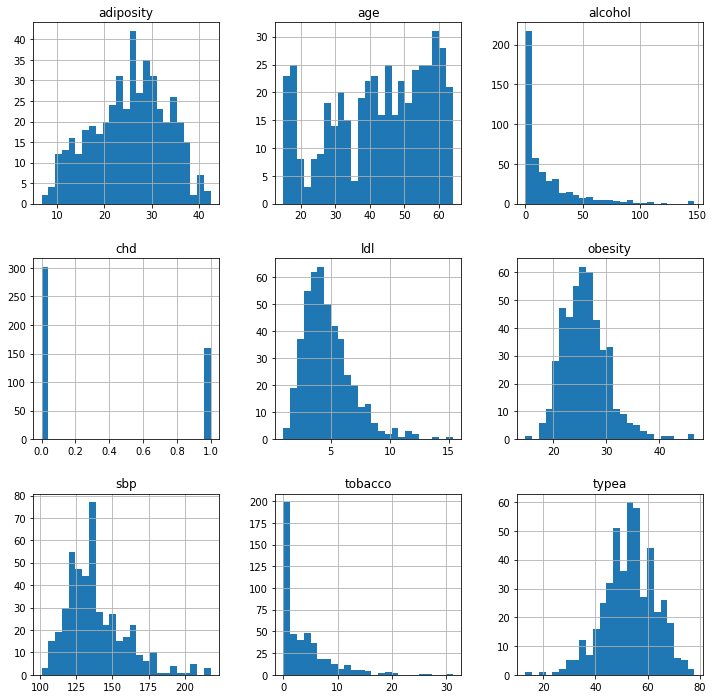

In [4]:
# plot distribution of (quantitative) features #
#----------------------------------------------#
SA.hist(bins = 25, figsize=(12,12))
plt.show()

## Question 2. Mettre en forme le jeu de données : 
 - 1 : extraire la variable réponse, qui est contenue dans le champ **chd**
     * NB : les fonctions du package **glmnet** attendent des variables réelles (float), il faut donc la convertir si ce n'est pas le cas.
 - 2 : transformer le descripteur qualitatif **famhist** en descripteur(s) quantitatifs
 - 3 : standardiser les descripteurs

In [5]:
# extract outcome #
#-----------------#
y = SA['chd']
SA = SA.drop('chd', axis = 1)
# convert to numpy
y = y.as_matrix()
y = y.astype('float') # NB : for glmnet, need to have float values for outcome

# format famhist #
#----------------#
famhist = SA['famhist']
Xnum = SA.drop("famhist", axis = 1)
# convert famhist to categorical using one-hot-encoding 
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
Xfamhist = encoder.fit_transform(famhist)
# merge back columns
Xraw = np.concatenate([Xnum, Xfamhist], axis = 1)

# standardize features #
#----------------------#
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X = std.fit_transform(Xraw)

## Question 3. Construire un modèle lasso avec la fonction *glmnet* et représenter le chemon de régularisation avec la fonction *glmnetPlot*. 
* NB : par défaut la fonction **glmnet** considère 100 valeurs du paramètre de régularisation défini automatiquement (se référer à la documentation pour davantage de précisions).

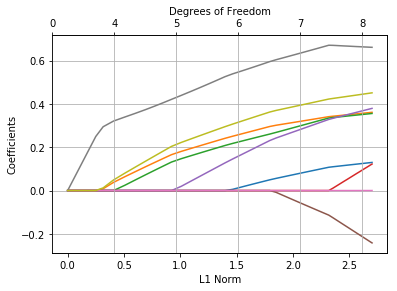

{'ax1': <matplotlib.axes._subplots.AxesSubplot at 0x7f9b4730ed30>,
 'ax2': <matplotlib.axes._subplots.AxesSubplot at 0x7f9b4733f6d8>,
 'fig': <matplotlib.figure.Figure at 0x7f9b49de9e10>}

In [6]:
# fit lasso model #
#-----------------#
# import package
import glmnet_python
# fit model
from glmnet import glmnet
fit_lasso = glmnet(x = X, y = y, family = 'binomial')
# plot model
from glmnetPlot import glmnetPlot 
glmnetPlot(fit_lasso)

## Question 4. Faire de même pour une pénalité "ridge".
* il suffit pour cela de modifier le paramètre $\texttt{alpha}$ qui contrôle la pénalité *elasticNet* considérée : $\Omega(w) = \alpha ||w||_1 + \frac{1-\alpha}{2} ||w||_2^2$.

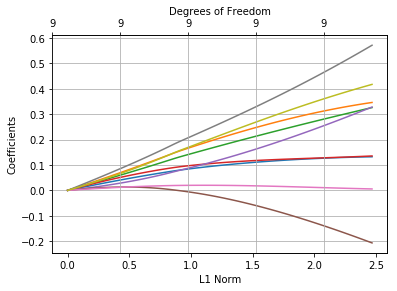

{'ax1': <matplotlib.axes._subplots.AxesSubplot at 0x7f9b3ea76160>,
 'ax2': <matplotlib.axes._subplots.AxesSubplot at 0x7f9b3eaa8d68>,
 'fig': <matplotlib.figure.Figure at 0x7f9b4756d7f0>}

In [7]:
# fit ridge model #
#-----------------#
fit_ridge = glmnet(x = X, y = y, family = 'binomial', alpha = 0)
# plot model
glmnetPlot(fit_ridge)

## Question 5. Optimiser le paramètre de régularisation de ces deux modèles en utilisant la fonction *cvglmnet* et représenter les résultats obtenus avec la fonction *cvglmnetPlot*.
* on considèrera le taux de bonne classification (accuracy) comme critère de performance, que l'on peut définir grâce à l'option $\texttt{ptype="class"}$.

/Softs/virtualenvPython/piedros/lib/python3.5/site-packages/glmnet_python/cvglmnetPlot.py:82: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/Softs/virtualenvPython/piedros/lib/python3.5/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/Softs/virtualenvPython/piedros/lib/python3.5/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


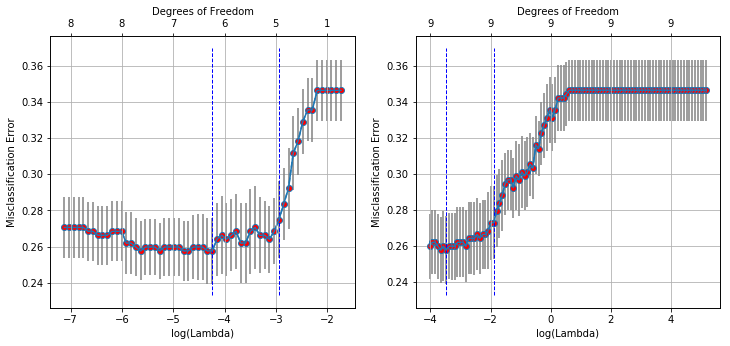

In [8]:
# carry out cross-validation to select lambda #
#---------------------------------------------#
from cvglmnet import cvglmnet
cvfit_lasso = cvglmnet(x = X, y = y, family = "binomial", ptype="class")
cvfit_ridge = cvglmnet(x = X, y = y, family = "binomial", ptype="class", alpha = 0)
# plot result
from cvglmnetPlot import cvglmnetPlot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
cvglmnetPlot(cvfit_lasso)
plt.subplot(1,2,2)
cvglmnetPlot(cvfit_ridge)
plt.show()

## Question 6. Extraire les coefficients retenus en utilisant la fonction *cvglmnetCoef()* pour les deux modèles et les comparer.
* on considèrera pour cela le paramètre $\texttt{s='lambda_1se'}$ qui ne considère pas le paramètre de régularisation donnant la valeur maximale de l'accuracy, mais qui tolère une performance sensiblement plus faible pour obtenir un modèle plus parcimonieux (en considérant donc une valeur de $\lambda$ plus importante).
* NB : on peut également utiliser la fonction **glmnetCoef()** pour extraire les coefficients à partir du fit global (obtenu par la fonction **glmnet()**). Dans ce cas on doit explicitement lui passer la valeur numérique du paramètre retenu, alors qu'avec **cvglmnetCoef()** on peut directement lui passer la chaine de caractère $\texttt{lambda_min}.$
* NB : le 1er coefficient renvoyé est l'intercept du modèle.

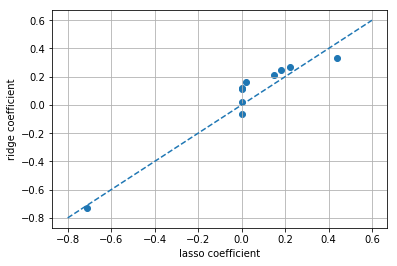

In [9]:
# extract best coefficients #
#---------------------------#
# extract coefficients from cv fit object
from cvglmnetCoef import cvglmnetCoef
beta_lasso = cvglmnetCoef(cvfit_lasso, s = 'lambda_1se') # NB : 1st coeff = intercept
beta_ridge = cvglmnetCoef(cvfit_ridge, s = 'lambda_1se')
# plot
plt.scatter(beta_lasso, beta_ridge)
plt.grid()
plt.xlabel('lasso coefficient')
plt.ylabel('ridge coefficient')
plt.plot([-0.8,0.6],[-0.8,0.6], ls ="--")
plt.show()

In [11]:
# NB : can also extract coefficients from initial objects
from glmnetCoef import glmnetCoef
glmnetCoef(fit_lasso, s = cvfit_lasso['lambda_1se'])

array([[-0.709774  ],
       [ 0.        ],
       [ 0.18084133],
       [ 0.14710942],
       [ 0.        ],
       [ 0.01953624],
       [ 0.        ],
       [ 0.        ],
       [ 0.43946957],
       [ 0.22215759]])

## Question 7. Extraire les prédictions correspondantes (sur les données d'apprentissage) via la fonction *cvglmnetPredict()*.
* par défaut cette fonction renvoie le score du modèle linéaire : $f(x) = \langle w,x \rangle +b$.
* on obtient la classe en spécifiant l'option $\texttt{ptype='class'}$
* on obtient la probabilité a posteriori d'être dans la classe positive n spécifiant l'option $\texttt{ptype='response'}$
* là aussi, on peut obtenir de la même manière les prédictions à partir du "fit" global ou du "fit" par validation croisée.

In [13]:
from cvglmnetPredict import cvglmnetPredict
preds_score = cvglmnetPredict(cvfit_lasso, newx = X, s = 'lambda_min')
preds_class = cvglmnetPredict(cvfit_lasso, newx = X, s = 'lambda_min', ptype = 'class')
preds_prob  = cvglmnetPredict(cvfit_lasso, newx = X, s = 'lambda_min', ptype = 'response')

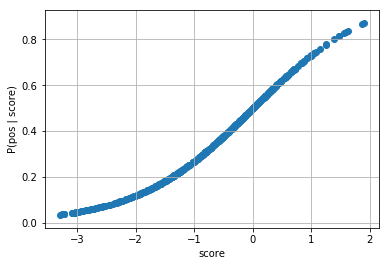

In [15]:
# compare score and predictions
plt.scatter(preds_score, preds_prob)
plt.grid()
plt.xlabel('score')
plt.ylabel('P(pos | score)')
plt.show()

/Softs/virtualenvPython/piedros/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


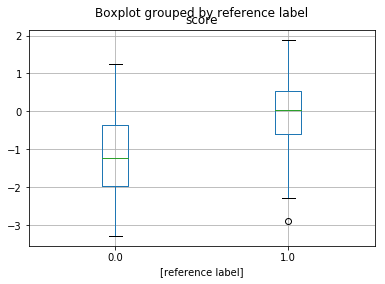

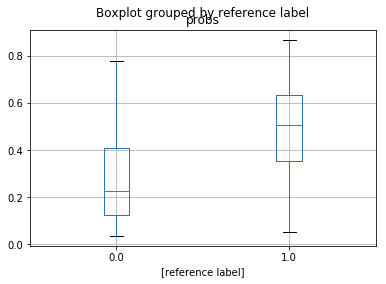

In [16]:
# show score vs label
d = {'reference label': y,
    'score': preds_score[:,0]
    }
res = pd.DataFrame(d)
res.boxplot(by='reference label')
plt.show()
# show prob vs label
d = {'reference label': y,
    'probs': preds_prob[:,0]
    }
res = pd.DataFrame(d)
res.boxplot(by='reference label')
plt.show()

In [17]:
# compute confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y, preds_class))

[[263  39]
 [ 77  83]]
